In [1]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

from neuralnet import NeuralNet
from data_processing import DataProcess

torch.set_printoptions(profile='full')
# torch.manual_seed(0)
# random.seed(0)

In [17]:
dp = DataProcess()
train_data, train_labels, test_data, test_labels = dp.get_separated_data()

learning_rate = 1e-4
batch_size = 64
epochs = 100
threshold = 0.5
zero_weight = 0.1

model = NeuralNet(hidden_dims=[60, 24])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [18]:
def test(model, x, y):
    model.eval()
    loss, acc = 0, 0
    
    y_ = model.forward(x)
    # loss = model.loss(y_, y, zero_weight).item()
    loss = criterion(y_, y).item()
    pred = y_ > threshold

    ones = torch.nonzero(y)[:, 0]
    zeros = torch.nonzero(y-1)[:, 0]
    
    tp = torch.sum(pred[ones]==1).item()
    fp = torch.sum(pred[ones]==0).item()
    fn = torch.sum(pred[zeros]==1).item()
    tn = torch.sum(pred[zeros]==0).item()
    
    tpr = tp / ones.size(dim=0)
    tnr = tn / zeros.size(dim=0)
    bal_acc = (tpr + tnr) / 2
    
    return loss / y.size(dim=0), bal_acc

100%|██████████| 100/100 [00:10<00:00,  9.96it/s]


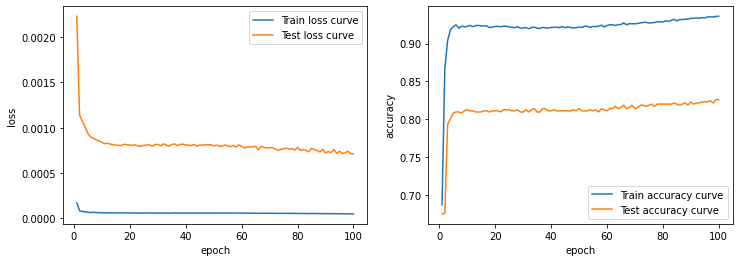

Training accuracy: 0.9361447158183063	Test accuracy: 0.8260385756676558


In [19]:
history = {'epoch': [], 
           'train_loss': [], 'train_acc': [],
           'test_loss': [], 'test_acc': []
          }

for epoch in tqdm(range(1, epochs + 1)):
    it = 0
    while it < len(train_data):
        ite = min(it + batch_size, len(train_data))
        idx = np.arange(it, ite)
        x, y = torch.Tensor(train_data[idx, :]), torch.Tensor(train_labels[idx, np.newaxis])
        it = ite

        y_ = model(x)
        loss = model.loss(y_, y, zero_weight)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    history['epoch'].append(epoch)

    train_loss, train_acc = test(model, torch.Tensor(train_data), torch.Tensor(train_labels[:, np.newaxis]))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    test_loss, test_acc = test(model, torch.Tensor(test_data), torch.Tensor(test_labels[:, np.newaxis]))
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, epochs+1), history['train_loss'])
axes[0].plot(range(1, epochs+1), history['test_loss'])
axes[0].legend(['Train loss curve', 'Test loss curve'])
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')


axes[1].plot(range(1, epochs+1), history['train_acc'])
axes[1].plot(range(1, epochs+1), history['test_acc'])
axes[1].legend(['Train accuracy curve', 'Test accuracy curve'])
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
# plt.savefig(f"curves_{zero_weight*100}.png")
plt.show()

print(f"Training accuracy: {history['train_acc'][-1]}\tTest accuracy: {history['test_acc'][-1]}")

In [20]:
model.eval()
for i in range(1, 10):
    threshold = i/10
    
    train_y = torch.Tensor(train_labels[:, np.newaxis])
    test_y = torch.Tensor(test_labels[:, np.newaxis])
    train_y_ = model.forward(torch.Tensor(train_data))
    test_y_ = model.forward(torch.Tensor(test_data))
    
    train_pred = (train_y_ > threshold)
    test_pred = (test_y_ > threshold)
    
    train1 = torch.nonzero(train_y)[:, 0]
    train0 = torch.nonzero(train_y-1)[:, 0]
    test1 = torch.nonzero(test_y)[:, 0]
    test0 = torch.nonzero(test_y-1)[:, 0]
    
    train_tp = torch.sum(train_pred[train1]==1).item()
    train_fp = torch.sum(train_pred[train1]==0).item()
    train_fn = torch.sum(train_pred[train0]==1).item()
    train_tn = torch.sum(train_pred[train0]==0).item()
    
    train_tpr = train_tp / train1.size(dim=0)
    train_tnr = train_tn / train0.size(dim=0)
    train_bal_acc = (train_tpr + train_tnr) / 2
        
    test_tp = torch.sum(test_pred[test1]==1).item()
    test_fp = torch.sum(test_pred[test1]==0).item()
    test_fn = torch.sum(test_pred[test0]==1).item()
    test_tn = torch.sum(test_pred[test0]==0).item()
    
    test_tpr = test_tp / test1.size(dim=0)
    test_tnr = test_tn / test0.size(dim=0)
    test_bal_acc = (test_tpr + test_tnr) / 2
    
    train_precision = train_tp / (train_tp + train_fp)
    test_precision = test_tp / (test_tp + test_fp)
    train_recall = train_tp / (train_tp + train_fn)
    test_recall = test_tp / (test_tp + test_fn)

    print(f"threshold = {threshold}")
    print(f"\ttrain:\tbalanced accuracy = {train_bal_acc:.4f}, precision = {train_precision:.2f}")
    print(f"\ttest:\tbalanced accuracy = {test_bal_acc:.4f}, precision = {test_precision:.2f}")
    # print(f"\ttrain:\tbalanced accuracy = {train_bal_acc:.4f}, F1 = {(2*(train_precision*train_recall/(train_precision+train_recall))):.4f}")
    # print(f"\ttest:\tbalanced accuracy = {test_bal_acc:.4f}, F1 = {(2*(test_precision*test_recall/(test_precision+test_recall))):.4f}")

threshold = 0.1
	train:	balanced accuracy = 0.8936, precision = 1.00
	test:	balanced accuracy = 0.7608, precision = 0.75
threshold = 0.2
	train:	balanced accuracy = 0.9183, precision = 1.00
	test:	balanced accuracy = 0.7815, precision = 0.75
threshold = 0.3
	train:	balanced accuracy = 0.9235, precision = 0.98
	test:	balanced accuracy = 0.8008, precision = 0.75
threshold = 0.4
	train:	balanced accuracy = 0.9260, precision = 0.96
	test:	balanced accuracy = 0.8157, precision = 0.75
threshold = 0.5
	train:	balanced accuracy = 0.9361, precision = 0.96
	test:	balanced accuracy = 0.8260, precision = 0.75
threshold = 0.6
	train:	balanced accuracy = 0.9461, precision = 0.96
	test:	balanced accuracy = 0.8335, precision = 0.75
threshold = 0.7
	train:	balanced accuracy = 0.9256, precision = 0.90
	test:	balanced accuracy = 0.5953, precision = 0.25
threshold = 0.8
	train:	balanced accuracy = 0.8943, precision = 0.83
	test:	balanced accuracy = 0.6027, precision = 0.25
threshold = 0.9
	train:	balanced